In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
def generate_3d_dipole_kernel(data_shape, voxel_size, b_vec):
    fov = np.array(data_shape) * np.array(voxel_size)
    #데이터의 필드오브뷰를 계산하기 위해 각 차원의 크기를 해당 복셀 크기로 곱해줌

    ry, rx, rz = np.meshgrid(np.arange(-data_shape[1] // 2, data_shape[1] // 2),
                             np.arange(-data_shape[0] // 2, data_shape[0] // 2),
                             np.arange(-data_shape[2] // 2, data_shape[2] // 2))
    #1차원 배열들을 기반으로 N차원의 격자를 생성

    rx, ry, rz = rx / fov[0], ry / fov[1], rz / fov[2]
    #각 좌표값이 각각의 축에 대한 다른 범위로 정규화된 좌표 생성

    sq_dist = rx ** 2 + ry ** 2 + rz ** 2 #원점으로부터 각 위치까지의 제곱거리
    sq_dist[sq_dist == 0] = 1e-6 #값이 0인 부분들을 0.0000001로 바꿔줌 -> 0으로 나눠지는 것 방지
    d2 = ((b_vec[0] * rx + b_vec[1] * ry + b_vec[2] * rz) ** 2) / sq_dist
    #rx,ry,rz를 b_vec 방향으로 투영한 값, 이 값은 b_vec 방향으로의 위치를 나타냄
    #디폴 커널 계산에 사용되는 중간변수

    
    kernel = (1 / 3 - d2)
    # 1/3은 이성질적 확산 성분에서 온 것 -> 모든 방향에서 동일한 확산
    # d2를 뺌으로써 이방성 확산 성분(물 분자가 특정 방향으로 더 빠르게 확산하는것)을 반영

    return kernel

def forward_convolution(chi_sample):
    scaling = np.sqrt(chi_sample.size) #입력데이터의 크기에 루트를 취한 값
    chi_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(chi_sample))) / scaling
    #np.fft.fftshift : FFT 결과의 주파수 영역을 중심(원점)에 위치시킴
    #np.fft.fftn : 다차원 배열의 FFT를 수행
    #np.fft.fftshift : 주파수 도메인 데이터를 다시 이미지 공간으로 되돌리기 위해 주파수 도메인에서의 중심을 이미지 공간으로 이동시킴
    #->이렇게 함으로써 fft의 결과가 원래 이미지 공간에서의 크기와 위치에 대응하도록 함
    #마지막에 scaling으로 나누어 정규화 수행
    
    chi_fft_t_kernel = chi_fft * dipole_kernel #주파수 도메인에서의 시그널에 디폴 커널의 영향을 반영
   
    tissue_phase = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(chi_fft_t_kernel)))
    #역 fft를 수행하여 이미지 도메인으로 돌아감
    tissue_phase = np.real(tissue_phase * scaling) #scailing을 곱하여 정규화하고 실수 부분을 추출

    return tissue_phase

def dipole_inversion(y):
    scaling = np.sqrt(y.size) #입력데이터에 루트 취해줌
    tp0 = y/scaling # y/root(y)
    xtk = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(tp0)))
    #np.fft.fftshift : FFT 결과의 주파수 영역을 중심(원점)에 위치시킴
    #np.fft.fftn : 다차원 배열의 FFT를 수행
    #np.fft.fftshift : 주파수 도메인 데이터를 다시 이미지 공간으로 되돌리기 위해 주파수 도메인에서의 중심을 이미지 공간으로 이동시킴
    #->이렇게 함으로써 fft의 결과가 원래 이미지 공간에서의 크기와 위치에 대응하도록 함
    x0 = xtk/dipole_kernel #푸리에 도메인에서의 값을 division해줌
    x0[np.isnan(x0)==1]=0 #nan값을 가지는 것들을 0으로 대체
    x0[np.isinf(x0)==1]=0 #infinity값을 가지는 것들을 0으로 대체
    x = np.real(np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(x0)))*scaling)
    #역FFT를 통해 이미지 공간으로 이동, scailing을 곱하여 정규화하고 실수 부분을 추출
    return x

def dipole_inversion_tkd(y,th):
    scaling = np.sqrt(y.size)
    tp0 = y/scaling
    xtk = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(tp0)))
    x0 = xtk/dipole_kernel
    x0[np.isnan(x0)==1]=0
    x0[np.isinf(x0)==1]=0
    x0[np.abs(dipole_kernel)<th]=np.sign(dipole_kernel)*th #티크노프 필터링을 적용하는 수식
    x = np.real(np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(x0)))*scaling)
    return x

In [3]:
msk = nib.load('/home/oem/hufsbaby/ycm/qsm/files/msk.nii.gz').get_fdata()
chi = nib.load('/home/oem/hufsbaby/ycm/qsm/files/Chi.nii.gz').get_fdata()
dipole_kernel = generate_3d_dipole_kernel(chi.shape, voxel_size=1., b_vec=[0, 0, 1])

In [4]:
# tissue phase generation from chi map (forward calculation)
tp = forward_convolution(chi)
#tp = forward_convolution(chi*msk
# 두개의 차이점을 알기(올바른 마스크의 중요성)

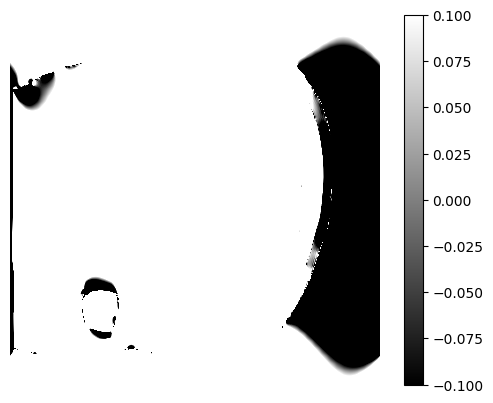

In [5]:
SN = 80
plt.imshow(tp[SN,:,:],cmap='gray',vmin=-.1, vmax=.1)
plt.colorbar()
plt.axis('off')
plt.show()

In [6]:
# QSM (inverse problem)
qsm = dipole_inversion(tp)

/tmp/ipykernel_3351448/9024491.py:51: RuntimeWarning: divide by zero encountered in divide
  x0 = xtk/dipole_kernel
/tmp/ipykernel_3351448/9024491.py:51: RuntimeWarning: invalid value encountered in divide
  x0 = xtk/dipole_kernel


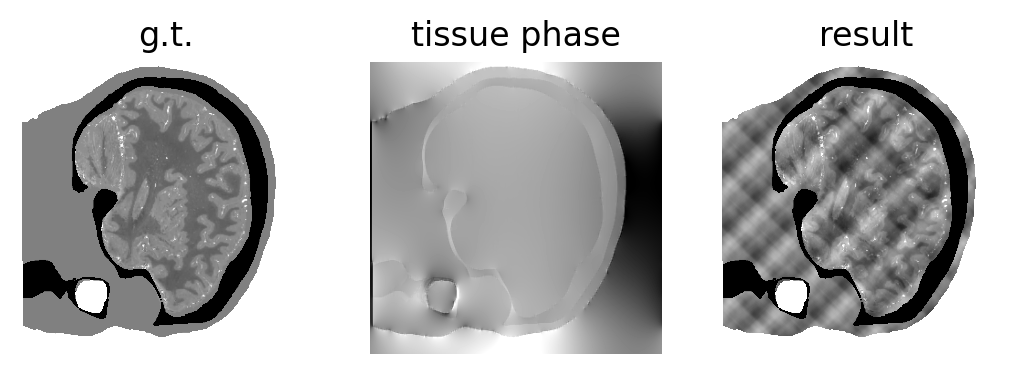

In [7]:

SN = 80
plt.figure(dpi=200)
plt.subplot(131)
plt.imshow(chi[SN,:,:],vmin=-.16,vmax=.16,cmap='gray')
plt.axis('off')
plt.title('g.t.')
plt.subplot(132)
plt.imshow(tp[SN,:,:],cmap='gray',vmin=-5,vmax=5)
plt.axis('off')
plt.title('tissue phase')
plt.subplot(133)
plt.imshow(qsm[SN,:,:],vmin=-.16,vmax=.16,cmap='gray')
plt.axis('off')
plt.title('result')
plt.show()